Epoch 20/20: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s, D_loss=0.541, G_loss=1.3]


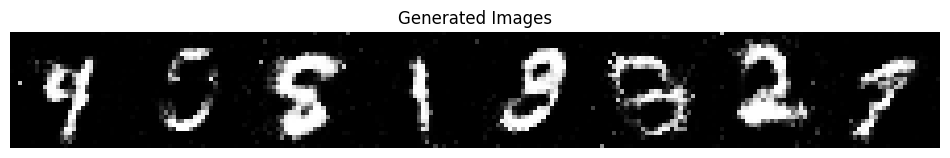

In [2]:
# GAN for MNIST: End-to-End PyTorch Implementation

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
batch_size = 128
lr = 0.0002
epochs = 20
img_size = 28
channels = 1

# Image preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, transform=data_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_size * img_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 1, img_size, img_size)
        return img

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size * img_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flat = img.view(img.size(0), -1)
        validity = self.model(flat)
        return validity

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for i, (imgs, _) in enumerate(pbar):

        real = imgs.to(device)
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        pbar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

# Sampling from Generator
def generate_images(generator, n_row=8):
    z = torch.randn(n_row, latent_dim, device=device)
    gen_imgs = generator(z).detach().cpu()
    gen_imgs = (gen_imgs + 1) / 2  # Rescale to [0, 1]
    grid = torch.cat([img.squeeze(0) for img in gen_imgs], dim=1)
    plt.figure(figsize=(12, 2))
    plt.imshow(grid.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()

generate_images(generator)
